In [6]:
from dask.distributed import Client
CLUSTER_TYPE ='cloudveneto_cluster'
#CLUSTER_TYPE ='docker_cluster'
%env CLUSTER_TYPE $CLUSTER_TYPE
if CLUSTER_TYPE =='docker_cluster':
    %env CLUSTER_TYPE $CLUSTER_TYPE
    client = Client('dask-scheduler:8786')
elif CLUSTER_TYPE == 'cloudveneto_cluster':
    %env CLUSTER_TYPE $CLUSTER_TYPE
    client = Client('10.67.22.164:8786')
else: print('Please, provide a valid cluster type')
client

env: CLUSTER_TYPE=cloudveneto_cluster
env: CLUSTER_TYPE=cloudveneto_cluster


<Client: 'tcp://10.67.22.164:8786' processes=9 threads=36, memory=70.58 GiB>

In [2]:
from time import time

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.dataframe as dd
from dask import compute
from dask import delayed
from dask.distributed import wait
import dask.bag as db

import dask_ml.datasets
import dask_ml.cluster

import sklearn as skl
import sklearn.cluster

import matplotlib.pyplot as plt

# Utils

In [3]:
# %load dask_utils.py

#we want to work with dask array, hence we trasform everything to dask arrays
def make_da(X):
        if isinstance(X, dd.DataFrame):
            X = X.to_dask_array(lengths=True)
            
        if isinstance(X, da.core.Array): 
            return X
        
        else: raise ValueError("input is neither a dask array nor a dask dataframe")
        return X

# Scalable K-means: K-means||

### Observation:
- The centroids should be a numpy array stored in the machine. This way we can calculate distances without having to move data accross the nodes. This would have happened if the centroids array was distributed throughout the nodes.

 

In [4]:
# %load k-means.py
import dask
import numpy as np
import dask.array as da
import dask_ml
import sklearn as skl


def OUR_pairwise_distances(X, centroids):
    ## our implementation, a bit slower than dask's.
    #def min_centroid(y): 
    #    return da.sum(da.square(X - y), axis=1)

    #return da.apply_along_axis(min_centroid, 1, centroids).T
    return dask_ml.metrics.pairwise_distances(X, centroids)

def evaluate_cost_and_dists(X, centroids): # (da.Array, np.array) -> float
    distances_matrix = OUR_pairwise_distances(X, centroids) 
    min_distances = da.min(distances_matrix, axis=1) 
    cost = min_distances.sum()
    return cost, da.power(min_distances, 2)

def get_min_distances(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    return da.power(min_distances, 2)

def get_closest_centroids_and_dists(X, centroids):
    distances_matrix = OUR_pairwise_distances(X, centroids)
    min_distances = da.min(distances_matrix, axis=1) 
    closest_centroids = da.argmin(distances_matrix, axis=1)
    return closest_centroids, da.power(min_distances, 2)
 
def oversample(X, distances, l):
    p = l * distances/distances.sum()
    return X[da.random.random(X.shape[0]) < p, :]

def k_means_pp_only_weights(c, weights, k):
    p = weights/weights.sum()
    idx = np.arange(c.shape[0])
    final_index = np.random.choice(idx, size=k, replace=False, p=p)
    return c[final_index]

def k_means_pp_without_weights(c, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_pp_weighted(c, weights, k):
    n = c.shape[0]
    idx = np.random.randint(0, n)
    centroids = c[idx, np.newaxis]
    idx = np.arange(n)
    while (centroids.shape[0] < k):
        distances = np.min(skl.metrics.pairwise_distances(c, centroids), axis=1)
        distances = distances * weights
        p = distances / distances.sum()
        centroids = np.vstack((centroids, c[np.random.choice(idx, size=1, replace=False, p=p)]))
    return centroids

def k_means_scalable(X, k, l): 
    X = make_da(X)
    n = X.shape[0]
    idx = np.random.randint(0, n)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        centroids = np.vstack((centroids, new_centroids))
        distances = get_min_distances(X, centroids)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(len(X), size=missing_centroids, replace=False)
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    centroids_pp = k_means_pp_weighted(centroids, centroid_counts, k)
    return centroids, centroids_pp 
    #Return initial centroids for Lloyd's algorithm (and previous cluster of centroids for visulization purposes)

def k_means_scalable_2(X, k, l): #this function doesn't compute ALL the distances every iteration.
    X = make_da(X)
    n_points, n_features = X.shape
    idx = np.random.randint(0, n_points)
    centroids = da.compute(X[idx, np.newaxis])[0] #compute() -> np array not stored on nodes.
    initial_cost, distances = da.compute(*evaluate_cost_and_dists(X ,centroids))
    iterations = int(np.round(np.log(initial_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        new_centroids = oversample(X, distances, l).compute()
        if np.shape(new_centroids) == (0, n_features):
            continue
        new_distances = get_min_distances(X, new_centroids)
        centroids = np.vstack((centroids, new_centroids))
        distances = da.minimum(new_distances, distances)
    if len(centroids) < k: 
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(len(X), size=missing_centroids, replace=False)
        additional_centroids = X[random_index[0]].compute()
        centroids = np.vstack((centroids, additional_centroids))
    closest_centroids, distances = get_closest_centroids_and_dists(X, centroids)
    result = da.unique(closest_centroids, return_counts=True)
    centroid_index, centroid_counts = compute(result)[0]
    centroids_pp = k_means_pp_weighted(centroids, centroid_counts, k)
    return centroids, centroids_pp #Return initial centroids for Lloyd's algorithm (and previous cluster of centroids for visulization purposes)


## Test function

In [10]:
n_workers=len(client.scheduler_info()['workers'])
N=9000
n_feat=2
chunks_per_worker=1
data, labels = dask_ml.datasets.make_blobs(N,n_features=n_feat ,centers=4, chunks=(int(N/n_workers/chunks_per_worker),n_feat))
data.persist()

dask.array<concatenate, shape=(9000, 2), dtype=float64, chunksize=(1000, 2), chunktype=numpy.ndarray>

In [11]:
%time oversample_centroids, centroids_pp = k_means_scalable(data, k=4, l=2)

CPU times: user 623 ms, sys: 7.9 ms, total: 631 ms
Wall time: 1.84 s


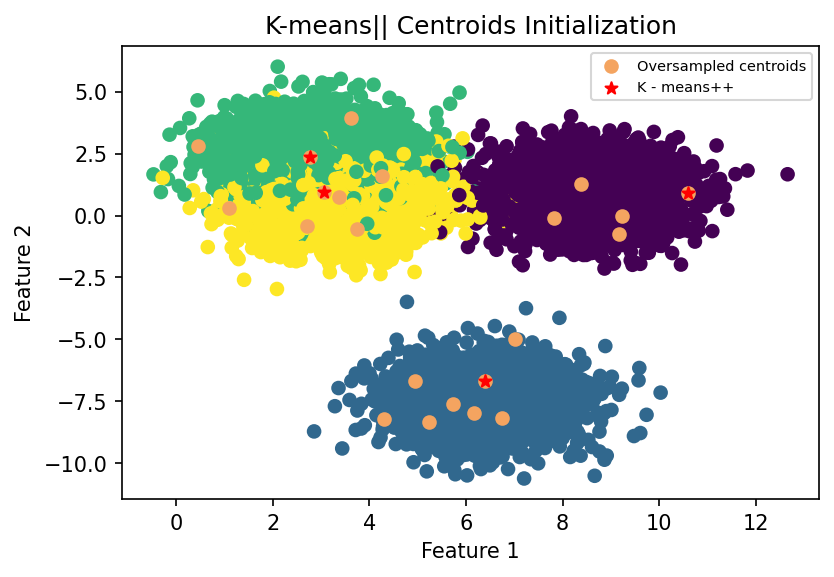

In [12]:
plt.figure(dpi=150)
plt.scatter(data[:,0], data[:,1], c= labels)
plt.scatter(oversample_centroids[:,0], oversample_centroids[:,1], c= 'sandybrown', label = "Oversampled centroids")
plt.scatter(centroids_pp[:,0], centroids_pp[:,1], c = 'red', marker = "*", label = "K - means++")
plt.title("K-means|| Centroids Initialization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(fontsize = 'x-small')
plt.show()

# Scalable Lloyd's Algorithm

### Using Dask Arrays

In [14]:
# %load distributed_lloyd.py
import numpy as np
import dask
import dask.array as da
import dask_ml

def lloyd_scalable (X, k, centroids = None, maxIter = 1000, patience = 1e-6):
    X = make_da(X)
    n_points, n_features = X.shape
    if centroids is None:
        random_index = np.random.choice(n_points, size=(1, k), replace=False)
        centroids = X[random_index[0]]
    epoch = 1
    loss_diff = patience + 1.
    loss = 0
    while (epoch < maxIter and loss_diff > patience):
        distances_matrix = dask_ml.metrics.pairwise_distances(X, np.array(centroids))
        indeces = da.argmin(distances_matrix, axis=1)
        new_loss = distances_matrix[indeces].sum()
        # Possible bug if new_centroids = zeros and we don't enter the for loop
        new_centroids = da.zeros((k, n_features))
        for i in range(indeces.max()+1):
            new_centroids[i] = X[indeces == i].mean(axis=0)
        epoch = epoch + 1
        loss_diff = da.absolute(new_loss - loss)
        centroids = new_centroids
        loss = new_loss
    return (centroids, indeces)


### Using Dask Dataframes

In [15]:
def lloyd_scalable_df(k, X, centroids = None, maxIter = 150, patience = 1e-7):
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = np.array(X[random_index[0]])
        
    closest_centroid = get_min_distances(X, centroids)[1]
    df=dd.from_array(da.hstack((X, closest_centroid[:,None])), chunksize=get_chunks(X))
    df=df.rename(columns={df.columns[-1]: 'closest_centroid'})
    dc=1 #fix this
    iteration=0
    while ((dc > patience) & (iteration< maxIter)):
        new_centroids= df.groupby('closest_centroid').mean().compute().to_numpy()
        x=df.drop('closest_centroid', axis=1).to_dask_array()
        df['closest_centroid'] = get_min_distances(x, centroids)[1]
        #dc= np.linalg.norm(new_centroids-centroids) #fix this
        centroids=new_centroids
        iteration +=1
    return centroids


In [15]:
%time results, pred_labels = da.compute(*lloyd_scalable(data, k=4, centroids = centroids_pp, maxIter=30))

CPU times: user 2.06 s, sys: 46.1 ms, total: 2.1 s
Wall time: 7.1 s


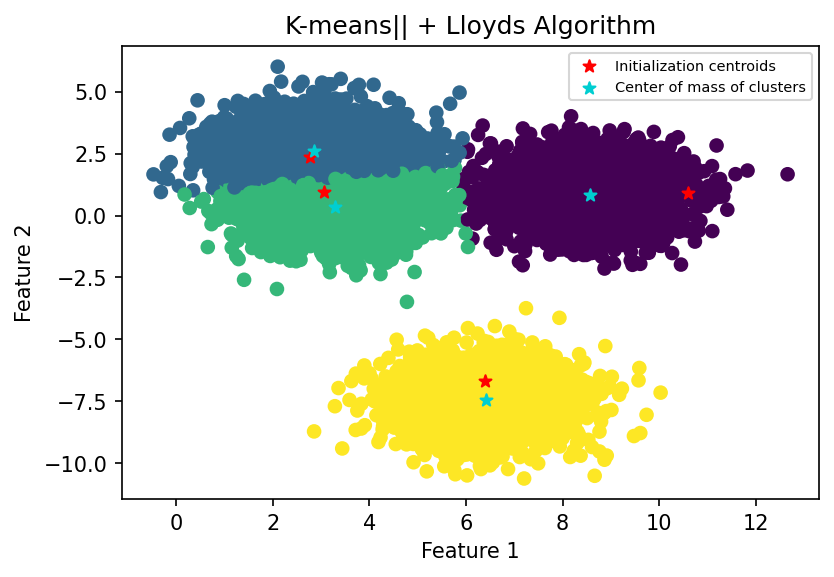

In [16]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(data[:,0], data[:,1], c=pred_labels)
plt.scatter(centroids_pp[:,0], centroids_pp[:,1], c='red', marker = '*', label = 'Initialization centroids')
plt.scatter(results[:,0], results[:,1], c = 'darkturquoise', marker = '*', label = 'Center of mass of clusters')
plt.title("K-means|| + Lloyds Algorithm")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(fontsize='x-small')
plt.show()

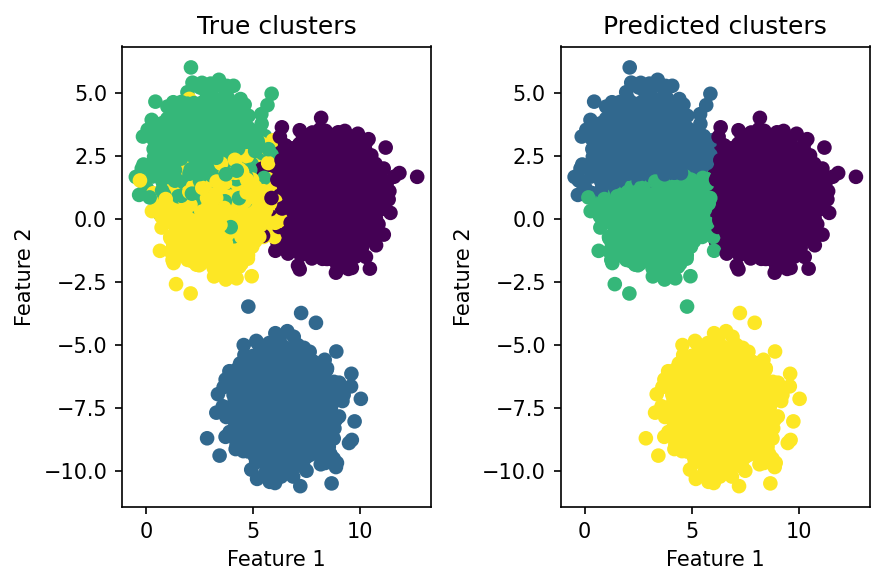

In [17]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[0].set_title('True clusters')

ax[1].scatter(data[:,0], data[:,1], c=pred_labels)
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
ax[1].set_title('Predicted clusters')

plt.tight_layout()
plt.show()

# Applying our Algorithm to the KDD Cup 1999 Data

This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between ''bad'' connections, called intrusions or attacks, and ''good'' normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html


In [20]:
KDD_data  = dd.read_csv('../data/KDD_features.csv') 
KDD_labels = dd.read_csv('../data/KDD_labels.csv') 

Let's repartition the dask dataframe in a number of partitions proportional to the total number of avalaible workers.

In [21]:
n_workers=len(client.scheduler_info()['workers'])
partitions_per_worker=16
KDD_data=KDD_data.repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=KDD_labels.repartition(npartitions=n_workers*partitions_per_worker)
KDD_data=KDD_data.drop(columns='Unnamed: 0')

In particular we focused only on the data about the connection based on the http service.
The resulting dataset has the following classes:

In [22]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203
3,4
2,1
4,1


Hence we only focus on the two most frequent labels:0,1.

In [23]:
KDD_data=dd.concat([KDD_data[KDD_labels.labels == 0], KDD_data[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)
KDD_labels=dd.concat([KDD_labels[KDD_labels.labels == 0], KDD_labels[KDD_labels.labels == 1]]).repartition(npartitions=n_workers*partitions_per_worker)

In [24]:
KDD_labels.groupby('labels').count().compute()

,Unnamed: 0
labels,
0,56516
1,2203


The features are the following:

In [25]:
KDD_data.columns

Index(['duration', 'src_bytes', 'dst_bytes'], dtype='object')

In [26]:
KDD_data.dtypes #checking that the inferred type are correct

duration     float64
src_bytes    float64
dst_bytes    float64
dtype: object

In [27]:
print('total number of samples:',len(KDD_data))

total number of samples: 58719


### Removing bad data

By exploring the dataset we found some values with duration, src_bytes and dst_bytes with negative values. This is non sensical, hence we will filter out this noise.

In [28]:
KDD_labels=KDD_labels.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]
KDD_data=KDD_data.loc[(KDD_data.dst_bytes > 0) & (KDD_data.src_bytes > 0) & (KDD_data.duration > 0)]

Let's store the final version of the dataset in the nodes.

In [29]:
KDD_data.persist()
KDD_labels=KDD_labels.drop(columns='Unnamed: 0')
KDD_labels.persist()

,labels
npartitions=64,
,int64
,...
...,...
,...
,...


Get a view:

In [30]:
KDD_data.head()

,duration,src_bytes,dst_bytes
132,1.131402,5.793318,5.861071
162,5.210032,5.752890,5.727173
175,1.808289,5.303802,4.852811
338,2.839078,5.820380,6.116113
580,0.095310,5.124559,8.738110


In [31]:
KDD_labels.head()

,labels
132,0
162,0
175,0
338,0
580,0


## Running K-means ||

In [ ]:
%time centroids_pp_w = k_means_scalable(KDD_data.to_dask_array(lengths=True), k=2, l=2)

In [ ]:
%time results, pred_labels = da.compute(*lloyd_scalable(KDD_data, k=2, centroids = centroids_pp_w, maxIter=30))

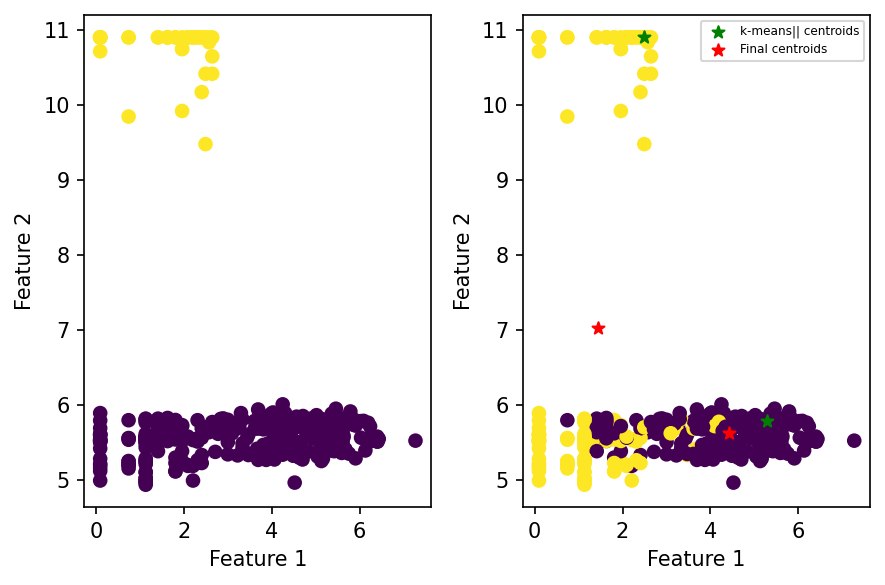

In [64]:
data=make_da(KDD_data)
labels=make_da(KDD_labels)
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[1].scatter(data[:,0], data[:,1], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,0], results[:,1], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

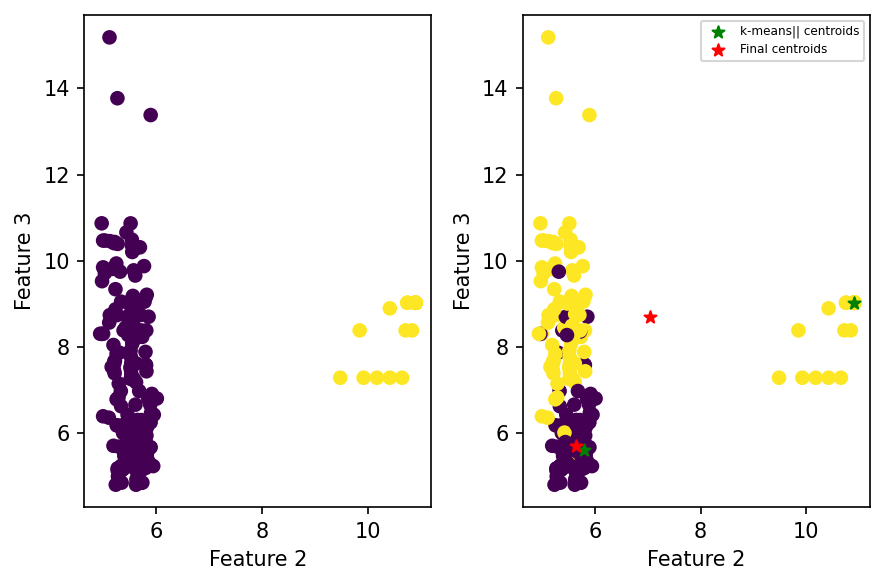

In [65]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,1], data[:,2], c=labels)
ax[1].scatter(data[:,1], data[:,2], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,1], centroids_pp_w[:,2], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,1], results[:,2], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 2')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 2')
ax[1].set_ylabel('Feature 3')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

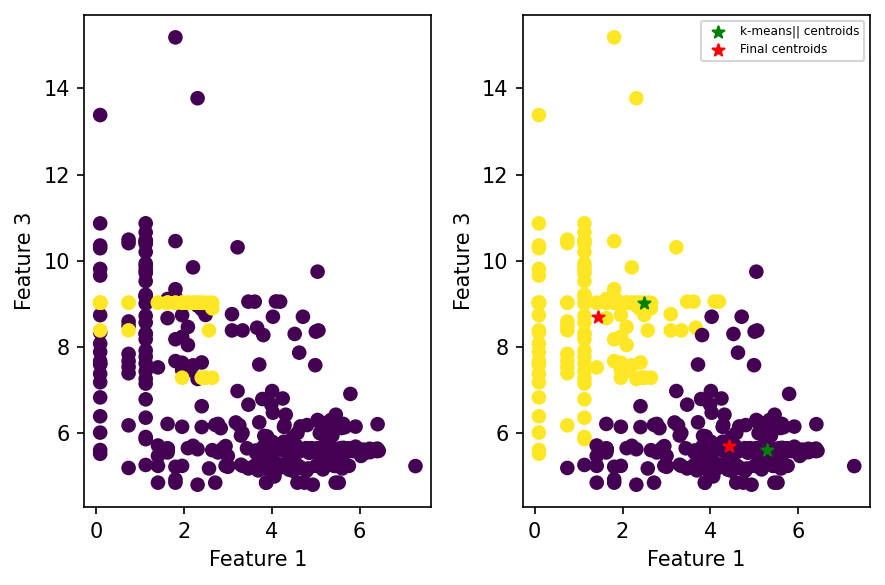

In [66]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(data[:,0], data[:,2], c=labels)
ax[1].scatter(data[:,0], data[:,2], c=pred_labels)
ax[1].scatter(centroids_pp_w[:,0], centroids_pp_w[:,2], marker = '*', c='green', label = 'k-means|| centroids')
ax[1].scatter(results[:,0], results[:,2], marker = '*', c='red', label='Final centroids')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 3')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 3')
ax[1].legend(loc='upper right', fontsize='xx-small')
plt.tight_layout()
plt.show()

In [69]:
model = dask_ml.cluster.KMeans(n_clusters=2)
model.fit(KDD_data)
dask_pred_labels=model.predict(KDD_data)

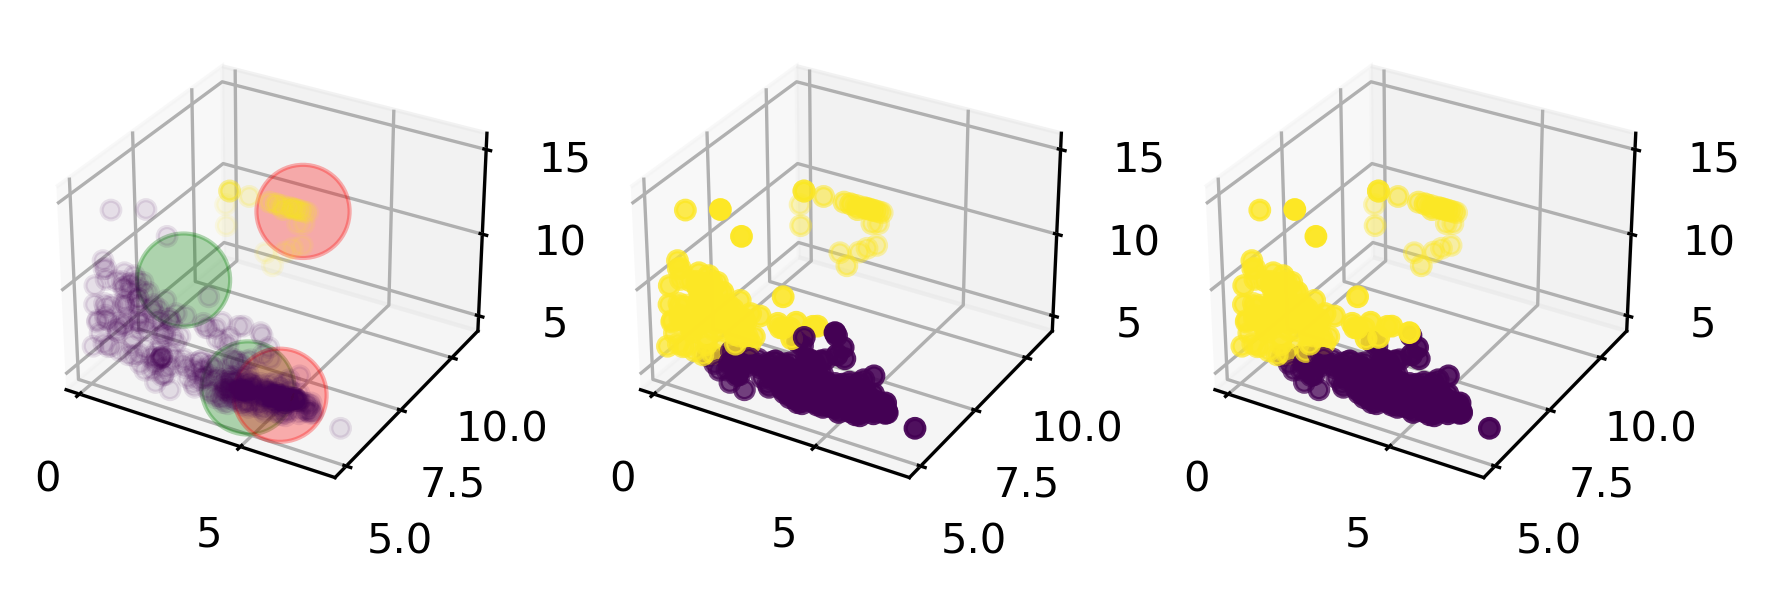

In [103]:
fig = plt.figure(dpi=300, figsize=(7, 7))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(centroids_pp_w[:,0], centroids_pp_w[:,1], centroids_pp_w[:,2], s=50, c='red', alpha=0.3)
ax.scatter(results[:,0], results[:,1], results[:,2], c='green', s=50,  alpha=0.3)
ax.scatter(data[:,0], data[:,1], data[:,2], c=labels, alpha=0.1)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=pred_labels)
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], c=dask_pred_labels)
plt.show()

Accuracy:

In [25]:
real_label=KDD_labels.to_dask_array().compute()
acc=skl.metrics.accuracy_score(real_label, pred_labels)
print(max(acc, 1-acc))

0.7538071065989848


# 3d make blob example

In [16]:
n_workers=len(client.scheduler_info()['workers'])
N=9000
n_feat=3
chunks_per_worker=1
data_3d, labels_3d = dask_ml.datasets.make_blobs(N,n_features=n_feat ,centers=5, chunks=(int(N/n_workers/chunks_per_worker),n_feat))
data_3d.persist()

dask.array<concatenate, shape=(9000, 3), dtype=float64, chunksize=(1000, 3), chunktype=numpy.ndarray>

### KMeans ||   initialization

In [43]:
%time oversampled_centroids, centroids_pp = k_means_scalable(data_3d, k=5, l=2)

CPU times: user 8.7 s, sys: 89.1 ms, total: 8.79 s
Wall time: 14.5 s


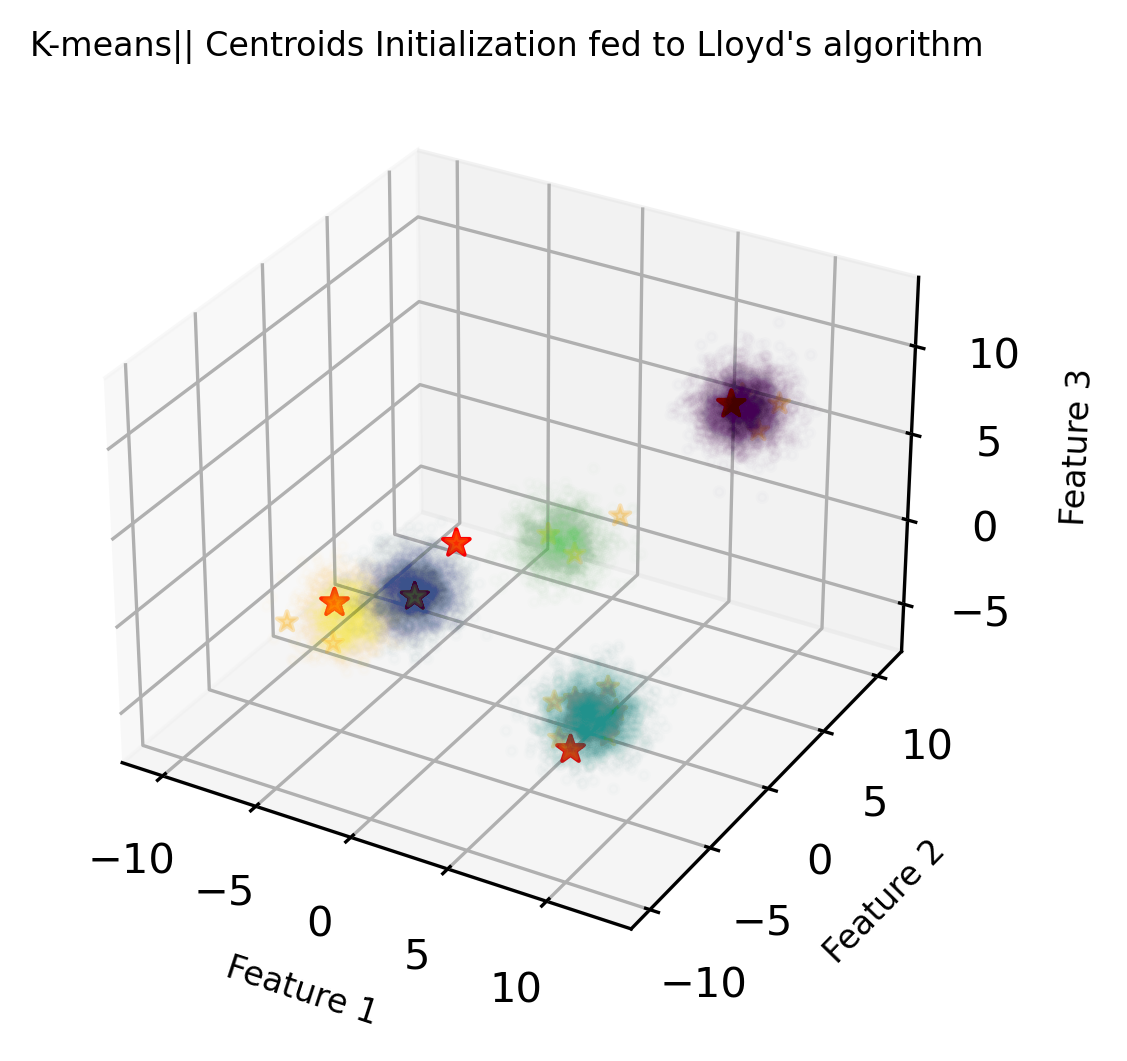

In [53]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], alpha=0.01, c=labels_3d, s=5)
ax.scatter(oversampled_centroids[:,0], oversampled_centroids[:,1], oversampled_centroids[:,2], s=25, alpha=0.25, c='orange', marker = '*')
ax.scatter(centroids_pp[:,0], centroids_pp[:,1], centroids_pp[:,2], s=45, alpha=1, c='red', marker = '*')
ax.set_title("K-means|| Centroids Initialization fed to Lloyd's algorithm", fontsize = 8)
ax.set_xlabel("Feature 1", fontsize = 8)
ax.set_ylabel("Feature 2", fontsize = 8)
ax.set_zlabel("Feature 3", fontsize = 8)
plt.show()

apply Lloyd's algorithm:

In [45]:
%time results, pred_labels = da.compute(*lloyd_scalable(data_3d, k=5, centroids = centroids_pp, maxIter=30))

CPU times: user 13.6 s, sys: 108 ms, total: 13.7 s
Wall time: 30 s


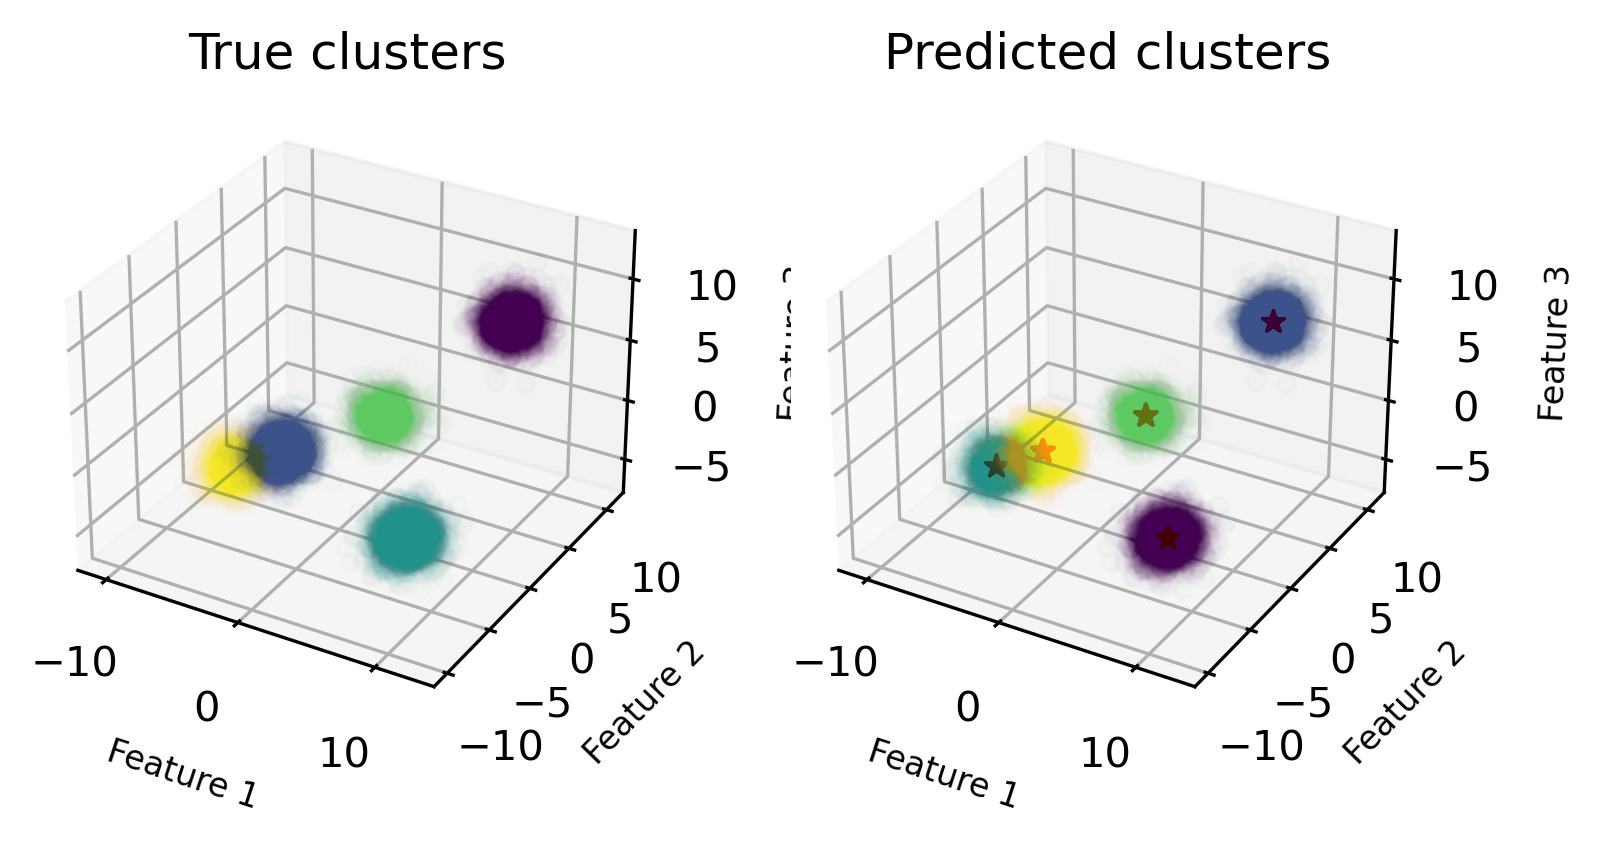

In [52]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c=labels_3d, alpha=0.01, s=20)
ax.set_title('True clusters')
ax.set_xlabel("Feature 1", fontsize = 8)
ax.set_ylabel("Feature 2", fontsize = 8)
ax.set_zlabel("Feature 3", fontsize = 8)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(data_3d[:,0], data_3d[:,1], data_3d[:,2], c=pred_labels, alpha=0.01, s=20)
ax.scatter(results[:,0], results[:,1], results[:,2], c='red', s=30, marker = '*',  alpha=1)
ax.set_title('Predicted clusters')
ax.set_xlabel("Feature 1", fontsize = 8)
ax.set_ylabel("Feature 2", fontsize = 8)
ax.set_zlabel("Feature 3", fontsize = 8)
plt.show()

# TV News Channel Commercial Detection Dataset 
### Data Set Information:

Automatic identification of commercial blocks in news videos finds a lot of applications in the domain of television broadcast analysis and monitoring. Commercials occupy almost 40-60% of total air time. Manual segmentation of commercials from thousands of TV news channels is time consuming, and economically infeasible hence prompts the need for machine learning based Method. Classifying TV News commercials is a semantic video classification problem. TV News commercials on particular news channel are combinations of video shots uniquely characterized by audio-visual presentation. Hence various audio visual features extracted from video shots are widely used for TV commercial classification. Indian News channels do not follow any particular news presentation format, have large variability and dynamic nature presenting a challenging machine learning problem. Features from 150 Hours of broadcast news videos from 5 different ( 3 Indian and 2 International News channels) news channels. Viz. CNNIBN, NDTV 24X7, TIMESNOW, BBC and CNN are presented in this dataset. Videos are recorded at resolution of 720 X 576 at 25 fps using a DVR and set top box. 3 Indian channels are recorded concurrently while 2 International are recorded together. Feature file preserves the order of occurrence of shots.

Labels : - +1/-1 ( Commercials/Non Commercials)

Motion Distribution( Mean and Variance) 

2 - 3 

Frame Difference Distribution ( Mean and Variance) 

4 - 5 

Short time energy ( Mean and Variance) 

6 - 7 

ZCR( Mean and Variance) 

8 - 9 

Spectral Centroid ( Mean and Variance) 

10 - 11 

Spectral Roll off ( Mean and Variance) 

12 - 13 

Spectral Flux ( Mean and Variance) 

14 - 15 

Fundamental Frequency ( Mean and Variance) 

16 - 17 

Motion Distribution ( 40 bins) 

18 - 58 

Frame Difference Distribution ( 32 bins) 

59 - 91 

Text area distribution ( 15 bins Mean and 15 bins for variance ) 

92 - 122 

Bag of Audio Words ( 4000 bins) 

123 - 4123 

Edge change Ratio ( Mean and Variance) 

4124 - 4125 

In [6]:
import os
path='../data/TIMESNOW_Cleaned.csv'
file_stats = os.stat(path)
print(f'File Size in Bytes is {file_stats.st_size}')
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')
n_worker=len(client.scheduler_info()['workers'])

File Size in Bytes is 10782693
File Size in MegaBytes is 10.283177375793457


In [7]:
df=dd.read_csv(path, blocksize=int(file_stats.st_size/n_worker)).drop(columns='Unnamed: 0')
tvlabel= df['Label'].map(lambda x: int((x+1)/2)).copy()
tvdata=df.drop(columns='Label').copy()
tvdata.persist()
tvlabel.persist()

Dask Series Structure:
npartitions=4
    int64
      ...
      ...
      ...
      ...
Name: Label, dtype: int64
Dask Name: map, 4 tasks

### Running K-means

In [8]:
%time centroids_pp_w = k_means_scalable(tvdata, k=2, l=2)

CPU times: user 9.02 s, sys: 157 ms, total: 9.17 s
Wall time: 7min 53s


In [9]:
%time results, pred_labels = da.compute(*lloyd_scalable(tvdata, k=2, centroids = centroids_pp_w, maxIter=30))

CPU times: user 7.02 s, sys: 132 ms, total: 7.16 s
Wall time: 1min 3s


Accuracy

In [11]:
real_label=tvlabel.to_dask_array().compute()
acc=skl.metrics.accuracy_score(real_label, pred_labels)
print(max(acc, 1-acc))

0.6470753082645471


### PCA

In [13]:
data_to_transform=tvdata.to_dask_array(lengths=True)
from dask_ml.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_to_transform)
print(pca.explained_variance_ratio_)  

[0.56125006 0.34398069]


In [15]:
decomposed_data=pca.transform(data_to_transform)

In [17]:
%time centroids_pp_w = k_means_scalable(decomposed_data, k=2, l=2)

CPU times: user 8.85 s, sys: 197 ms, total: 9.05 s
Wall time: 11min 20s


In [19]:
%time results, pred_labels = da.compute(*lloyd_scalable(decomposed_data, k=2, centroids = centroids_pp_w, maxIter=30))

CPU times: user 7.81 s, sys: 144 ms, total: 7.95 s
Wall time: 1min 23s


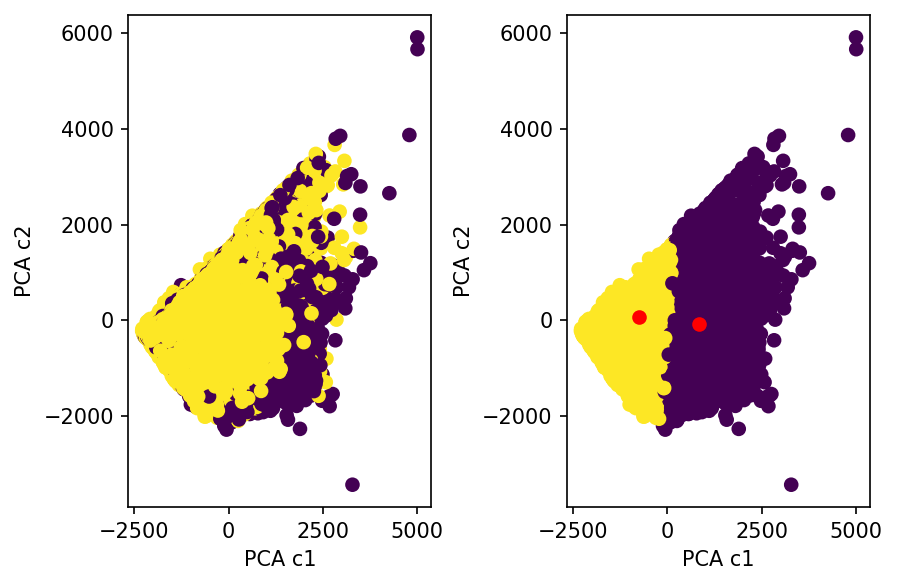

In [21]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].scatter(decomposed_data[:,0], decomposed_data[:,1], c=real_label)
ax[1].scatter(decomposed_data[:,0], decomposed_data[:,1], c=pred_labels)
ax[1].scatter(results[:,0], results[:,1],c='red')
ax[0].set_xlabel('PCA c1')
ax[0].set_ylabel('PCA c2')
ax[1].set_xlabel('PCA c1')
ax[1].set_ylabel('PCA c2')
plt.tight_layout()
plt.show()

Accuracy:

In [23]:
acc=skl.metrics.accuracy_score(real_label, pred_labels)
print(max(acc, 1-acc))

0.6471007846733925


## Benchmarking

    The tested parameters in setup are:
     - number of threads
     - number of vcpu's
     - check if our optimized algorithm is faster
     - number/size of chunks

    We used the same dataset for the whole benchmark process. The dataset contained 20000 samples with 3 
    features, 8 centroids and we used an oversampling of 2.

In [18]:
# thread benchmark
threads_x = np.array([9, 18, 36])
threads_y = np.array([25.8, 25.7, 26.2])
threads_std = np.array([519, 618, 792])/1000

#vcpu benchmark
vcpu_x = np.array([36, 32, 4])
vcpu_y = np.array([26.2, 25.9, 35.5])
vcpu_std = np.array([792, 692, 446])/1000

#algo benchmark
algo_x = np.array(['All', 'New centroids'])
algo_y = np.array([26.2 ,27.2])
algo_std = np.array([792, 552])/1000

#chunk benchmark
chunk_x = np.array([1, 2, 9, 18, 36, 72, 144, 288])
chunk_y = np.array([24.3, 25.3, 25.8, 23.5, 25.5, 27.5, 33.7, 44.1])
chunk_std = np.array([177, 911, 650, 79.7, 764, 968, 1.45, 1.44])/1000

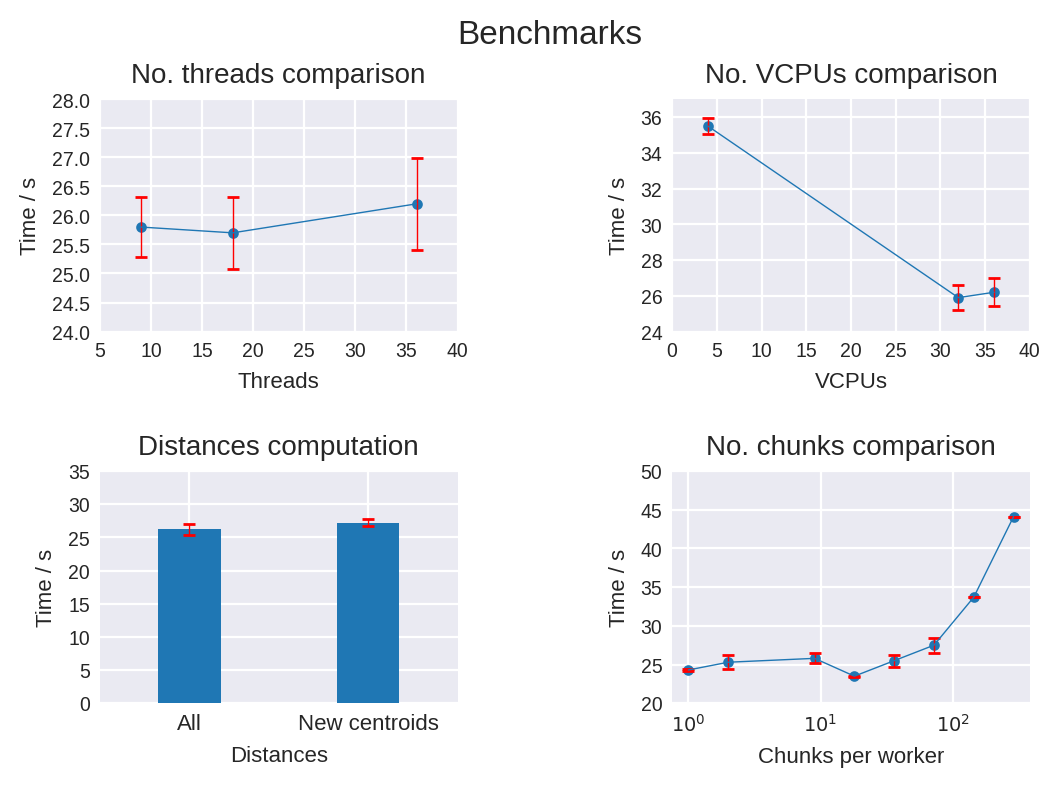

In [33]:
import seaborn as sns
plt.style.use('seaborn-darkgrid')

size = 8

fig, ax = plt.subplots(2, 2, dpi=200, gridspec_kw ={'wspace':0.6, 'hspace':0.6})
fig.suptitle('Benchmarks')

ax[0][0].scatter(threads_x, threads_y, s=8)
ax[0][0].errorbar(threads_x, threads_y, threads_std, linewidth=0.5, capsize=2, ecolor='red')
ax[0][0].set_yticks(np.arange(24, 28.1, 0.5))
ax[0][0].set_yticklabels(np.arange(24, 28.1, 0.5), fontsize=7)
ax[0][0].set_xticks(np.arange(0, 41, 5))
ax[0][0].set_xticklabels(np.arange(0, 41, 5), fontsize=7)
ax[0][0].set_xlim([5, 40])
ax[0][0].set_ylim([24, 28])
ax[0][0].set_xlabel('Threads', fontsize=size)
ax[0][0].set_ylabel('Time / s', fontsize=size)
ax[0][0].set_title('No. threads comparison', fontsize=10)

ax[0][1].scatter(vcpu_x, vcpu_y, s=8)
ax[0][1].errorbar(vcpu_x, vcpu_y, vcpu_std, linewidth=0.5, capsize=2, ecolor='red')
ax[0][1].set_yticks(np.arange(22, 38, 2))
ax[0][1].set_yticklabels(np.arange(22, 38, 2), fontsize=7)
ax[0][1].set_xticks(np.arange(0, 41, 5))
ax[0][1].set_xticklabels(np.arange(0, 41, 5), fontsize=7)
ax[0][1].set_xlim([0, 40])
ax[0][1].set_ylim([24, 37])
ax[0][1].set_xlabel('VCPUs', fontsize=size)
ax[0][1].set_ylabel('Time / s', fontsize=size)
ax[0][1].set_title('No. VCPUs comparison', fontsize=10)

ax[1][0].bar([1, 3], algo_y, width=0.7, yerr=algo_std ,error_kw={'ecolor':'red', 'capsize':2, 'linewidth':0.5})
ax[1][0].set_yticks(np.arange(0, 41, 5))
ax[1][0].set_yticklabels(np.arange(0, 41, 5), fontsize=7)
ax[1][0].set_xticks([1, 3])
ax[1][0].set_xticklabels(algo_x, fontsize=size)
ax[1][0].set_xlim([0, 4])
ax[1][0].set_ylim([0, 35])
ax[1][0].set_ylabel('Time / s', fontsize=size)
ax[1][0].set_xlabel('Distances', fontsize=size)
ax[1][0].set_title('Distances computation', fontsize=10)

ax[1][1].scatter(chunk_x, chunk_y, s=8)
ax[1][1].errorbar(chunk_x, chunk_y, chunk_std, linewidth=0.5, capsize=2, ecolor='red')
ax[1][1].set_xlabel('Chunks per worker', fontsize=size)
ax[1][1].set_ylabel('Time / s', fontsize=size)
ax[1][1].set_ylim([20, 50])
ax[1][1].semilogx()
ax[1][1].set_yticks(np.arange(20, 51, 5))
ax[1][1].set_yticklabels(np.arange(20, 51, 5), fontsize=7)
ax[1][1].set_xticks([1, 10, 100], fontsize = 7)
ax[1][1].set_xticklabels(['$10^0$', '$10^1$', '$10^2$'], fontsize=7)
ax[1][1].set_title('No. chunks comparison', fontsize = 10)

plt.show()